# Solution: Performing maximum likelihood estimation
First, load the dataset with the reported number of cases over time, along with the simple SIR model function and the input we used in previous weeks. 

In [1]:
# Load the flu dataset of reported cases
reported_data <- read.csv("../../IDM2/Graphics and Data/idm2_sir_reported_data.csv")

# Load packages
require(deSolve)
require(ggplot2)

# Set up initial model state and times vector
initial_state_values <- c(S = 762,  
                          I = 1,       
                          R = 0)

times <- seq(from = 0, to = 14, by = 0.1)

# Define the Susceptible-Infected-Recovered model
SIR_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
      
    N <- S+I+R
    lambda <- beta * I/N
    
    # The differential equations
    dS <- -lambda * S               
    dI <- lambda * S - gamma * I
    dR <- gamma * I             
    
    # Output
    return(list(c(dS, dI, dR))) 
  })
}

Loading required package: deSolve
Loading required package: ggplot2


Then, define a function (the **distance function** described in the lecture) that simulates the model for a given combination of parameters, then calculates the Poisson log-likelihood for the epidemic curve of reported cases.

We'll adjust for the 60% reporting rate by reducing cases returned by the model the model output accordingly.

In [2]:
# Define a function to calculate the distance between between the SIR model output
# and observed epidemiological data, using log-likelihood.
# As our flu dataset refers to reported cases, we need to make a corresponding adjustment to the model output.
# In case we'd like to use this function with other datasets (which may have a different reporting rate), we'll pass
# this value as a function argument.
# Arguments:
#    'parameters': must contain beta and gamma model parameters
#    'reported_data': will be the data to compare with. Note we have sometimes called this 'dat' instead.
#    'reporting_rate': refers to the proportion of actual cases which are reported, expressed as a fraction
SIR_loglik <- function(parameters, reported_data, reporting_rate) {   # takes as inputs the parameter values and dataset
  
   beta <- parameters[1]    # extract and save the first value in the "parameters" input argument as beta
   gamma <- parameters[2]   # extract and save the second value in the "parameters" input argument as gamma
    
   # Simulate the model with initial conditions and timesteps defined above, and parameter values from function call
   output <- as.data.frame(ode(y = initial_state_values, 
                               times = times, 
                               func = SIR_model,
                               parms = c(beta = beta,       # ode() takes the values for beta and gamma extracted from
                                         gamma = gamma)))   # the "parameters" input argument of the SIR_loglik() function

   # Ensure we're working with equivalent time points by selecting elements
   # where output$time is in reported_data$time
   matched_results <- output$I[output$time %in% reported_data$time]

   # Calculate log-likelihood, accounting for the reporting rate by reducing cases in the model output accordingly.
   # Note that lambda here has to do with the shape of the Poisson distribution, and is nothing to do with lambda 
   # in the epidemiological sense.
   LL <- sum(dpois(x = reported_data$number_reported, lambda = reporting_rate * matched_results, log = TRUE))
    
   return(LL) 
}

Finally, optimise this function using ```optim()``` to find the values for $\beta$ and $\gamma$ giving the highest log-likelihood value as output:

In [3]:
# Run optimisation
optim(par = c(1.7, 0.1),             # starting values for beta and gamma - you should get the same result no matter 
                                     # which values you choose here
      fn = SIR_loglik,               # the distance function to optimise
      reported_data = reported_data, # the dataset to fit to
      reporting_rate = 0.6,          # the proportion of actual cases which are reported, 60% in this case
      control = list(fnscale=-1))    # tells optim() to look for the maximum number instead of the minimum (the default)

$par
[1] 1.6915096 0.4764014

$value
[1] -59.23995

$counts
function gradient 
      51       NA 

$convergence
[1] 0

$message
NULL

The "par" argument of optim() gives maximum-likelihood estimates of 1.69 and 0.48 for $\beta$ and $\gamma$, respectively. With those parameters, the log-likelihood equals -59.24 ("value").

Confirm that these parameter values indeed produce a good visual fit to the real data of all infected cases. In the plot below we have also added the number of reported cases for comparison.

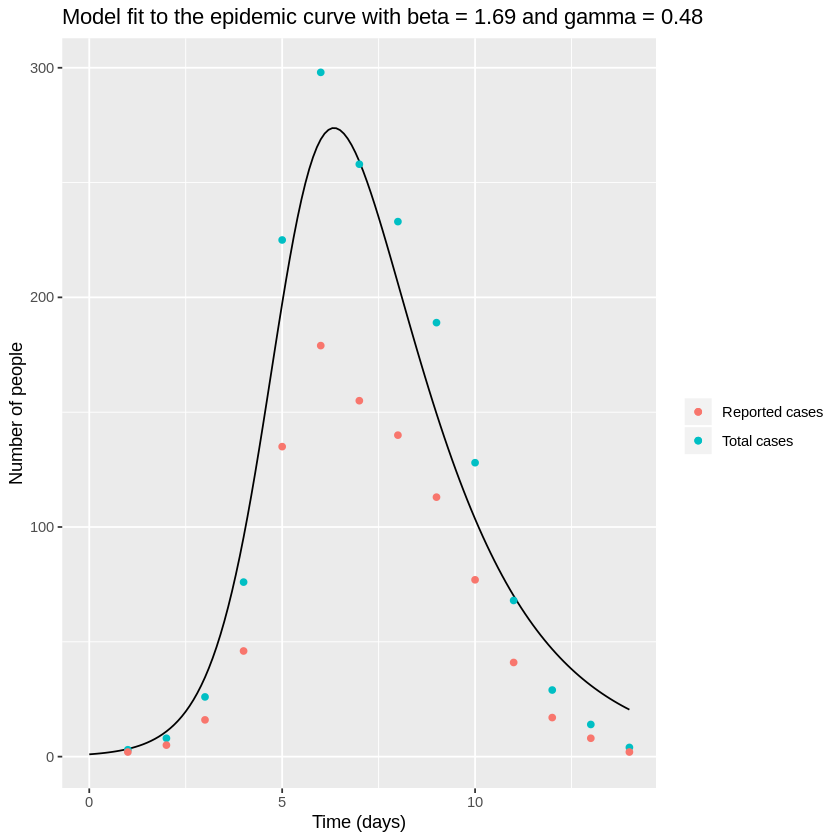

In [4]:
# Load the real flu dataset of the total number infected
full_data <- read.csv("../../IDM2/Graphics and Data/idm2_sir_data.csv")

# Simulate the model with the estimated best-fitting parameter values
parameters <- c(beta = 1.69,
                gamma = 0.48)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = SIR_model,
                            parms = parameters))

# Plot of the model fit
ggplot() +
  geom_line(data = output, aes(x = time, y = I)) +                              
  geom_point(data = full_data, aes(x = time, y = number_infected, colour = "Total cases")) +  
  geom_point(data = reported_data, aes(x = time, y = number_reported, colour = "Reported cases")) + 
  xlab("Time (days)")+                                              
  ylab("Number of people") +                                 
  labs(title = paste("Model fit to the epidemic curve with beta =", parameters["beta"], 
                     "and gamma =", parameters["gamma"]), colour = "")

As you can see, calibrating the model to the number of reported cases and accounting for the reporting rate gives us a good fit to the total number of infections. In reality, in outbreaks we usually only have the number of reported cases, so with an assumption of the reporting rate we can use the model to predict the total number of current and future infections.